# Inception v3 (Exercise 11-1)
Exercise Sung Kim lesson 11: Advanced CNN<br>
https://arxiv.org/abs/1602.07261<br>
Secret Sauce: `git@github.com:Cadene/pretrained-models.pytorch.git`<br>
He has well defined `stride and padding`!<br>
Test with CIFAR-10. Because it is small dataset and I have base line at 98% or more accuracy

## Smallest possible size is (150, 150, 3)
Watch out CIFAR-10 is 32x32. Then `PyTorch` will raise `std::exception`<br>
https://stackoverflow.com/questions/42522006/how-to-input-cifar10-into-inceptionv3-in-keras

In [31]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

torch.manual_seed(151)
use_cuda = torch.cuda.is_available()
device = 'cpu'

In [32]:
use_cuda

False

In [40]:
print('==> Preparing data..')
transform_data = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_data)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_data)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


# Show some training images, for fun

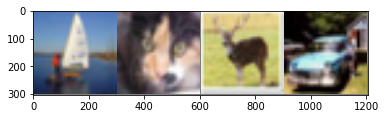

 ship   cat  deer   car


In [41]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [65]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(cm)
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def train(model, device, train_loader, optimizer, epoch, criterion):
    model.train()
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output[0], target)
        loss.backward()
        optimizer.step()
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    y_test = []
    y_pred = []
    with torch.no_grad():
        for data, target in tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            pred = model(data)
            y_test += list(target)
            y_pred += list(pred[0].view_as(target))
            correct += pred[0].eq(target.view_as(pred)).sum().item()


    print(f'Test set: Accuracy: {correct/len(test_loader.dataset)}')
    
    # Confusion matrix
    confusion_mtx = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(confusion_mtx, classes=classes, normalize=True,
                          title='Confusion matrix')


# 1. Model

Use ready-made from [`PyTorch`](https://pytorch.org/docs/stable/_modules/torchvision/models/inception.html#inception_v3)

In [66]:
from torchvision.models import Inception3
model = Inception3(num_classes=10, transform_input=True)

# 2. Loss & Optimizer
criterion has been absorbed to the `train and test` functions already

In [67]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [68]:
for epoch in range(1, 1 + 1):
    train(model, 'cpu', trainloader, optimizer, epoch, criterion)
    test(model, 'cpu', testloader, criterion)




  0%|          | 0/12500 [00:00<?, ?it/s]


  0%|          | 1/12500 [00:18<65:24:25, 18.84s/it]

Train Epoch: 1 [0/50000 (0%)]	Loss: 3.559314





  0%|          | 2/12500 [00:31<59:22:43, 17.10s/it]


  0%|          | 3/12500 [00:36<46:34:52, 13.42s/it]

KeyboardInterrupt: 

# Scratch Note

In [13]:
target = torch.tensor([3, 2 ,2, 4], dtype=torch.long)
pred = torch.tensor([8,2,2,4], dtype=torch.long)

In [14]:
y_test = list(target)
y_pred = list(pred)

[[2 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 0 0]]


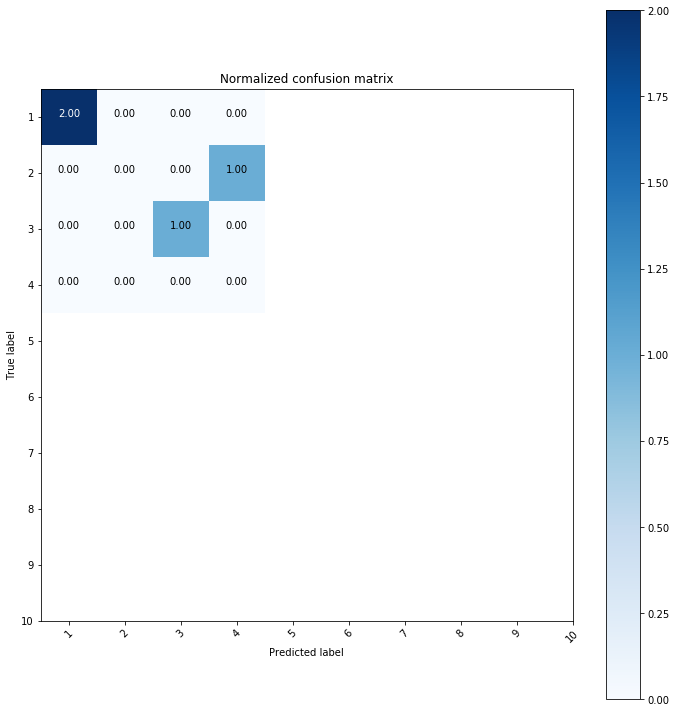

In [15]:
confusion_mtx = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion_mtx, classes=[i for i in range(1, 10 + 1)], normalize=True,
                      title='Normalized confusion matrix')
